# Zenodo Journal Runner Detection - Exploratory Data Analysis

This notebook performs an explainable exploratory analysis of Zenodo records to identify users who appear to be running journals on the platform.

## Overview
- **Data Source**: 500,000+ JSON records from Zenodo (2025)
- **Goal**: Identify users with journal-running behavior patterns
- **Approach**: Feature engineering based on explainable heuristics

## 1. Configuration and Setup

In [1]:
# Configuration
import os
import json
import glob
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Statistics
from scipy import stats

# Set up plotting style
plt.style.use('seaborn-v0_8')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 10

# Create output directories
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Configuration parameters
CONFIG = {
    'json_dir': 'records-json-2025',
    'spam_file': 'records-deleted-2025.csv',
    'sample_size': None,  # Set to number for sampling, None for full dataset
    'chunk_size': 1000,   # Process files in chunks
    'min_records_threshold': 20,
    'external_doi_consistency_threshold': 0.7,  # 70% of external DOIs use same prefix
    'max_external_prefixes': 3,  # Max unique external DOI prefixes
    'min_upload_regularity': 0.1,  # Much more mild upload regularity threshold (was 0.3)
    'max_spam_ratio': 0.1,  # Max 10% spam records
    # Safe communities that indicate independent users (not journal runners)
    'safe_communities': ['eu', 'biosyslit'],  # EU Open Research Repository and Biodiversity Literature Repository
    'repetitive_author_threshold': 0.3,  # If 30% of entries have no author intersection, likely journal runner
    'min_author_intersection_ratio': 0.2  # Minimum ratio of entries that share at least one author
}

print(f"Configuration loaded. Processing directory: {CONFIG['json_dir']}")
print(f"Spam records file: {CONFIG['spam_file']}")

Configuration loaded. Processing directory: records-json-2025
Spam records file: records-deleted-2025.csv


## 2. Data Loading Functions

In [2]:
def load_spam_records(filepath):
    """Load spam records CSV file."""
    print(f"Loading spam records from {filepath}...")
    spam_df = pd.read_csv(filepath)
    print(f"Loaded {len(spam_df)} spam records")
    return spam_df

def extract_record_features(record):
    """Extract relevant features from a single JSON record."""
    try:
        # Basic record info
        record_id = record.get('id')
        created = record.get('created')
        
        # User info
        user_id = record.get('parent', {}).get('access', {}).get('owned_by', {}).get('user')
        
        # DOI info
        doi = record.get('pids', {}).get('doi', {}).get('identifier', '')
        is_zenodo_doi = doi.startswith('10.5281/zenodo.') if doi else False
        
        # External DOI prefix (for consistency analysis)
        external_doi_prefix = None
        if doi and not is_zenodo_doi and '/' in doi:
            external_doi_prefix = doi.split('/')[0]
        
        # Journal info
        journal_title = None
        if 'custom_fields' in record and \
           'journal:journal' in record['custom_fields']:
            journal_title = record['custom_fields']['journal:journal'].get('title')
        
        # Author analysis - extract all author names from the full author list
        creators = record.get('metadata', {}).get('creators', [])
        n_authors = len(creators) if creators else 0
        
        # Extract all author names for intersection analysis
        author_names = []
        if creators:
            for creator in creators:
                if 'person_or_org' in creator and 'name' in creator['person_or_org']:
                    author_names.append(creator['person_or_org']['name'])
        
        # Title analysis
        title = record.get('metadata', {}).get('title', '')
        
        # Community info - check both main record and parent, extract slug
        communities = []
        community_slugs = []
        if 'communities' in record and 'ids' in record['communities']:
            communities = record['communities']['ids']
        elif 'parent' in record and 'communities' in record['parent'] and 'ids' in record['parent']['communities']:
            communities = record['parent']['communities']['ids']
        
        # Extract community slugs
        if 'parent' in record and 'communities' in record['parent'] and 'entries' in record['parent']['communities']:
            for entry in record['parent']['communities']['entries']:
                if 'slug' in entry:
                    community_slugs.append(entry['slug'])
        
        # File info
        file_count = record.get('files', {}).get('count', 0)
        
        return {
            'record_id': record_id,
            'user_id': user_id,
            'created': created,
            'doi': doi,
            'is_zenodo_doi': is_zenodo_doi,
            'external_doi_prefix': external_doi_prefix,
            'journal_title': journal_title,
            'n_authors': n_authors,
            'author_names': author_names,
            'title': title,
            'communities': communities,
            'community_slugs': community_slugs,
            'file_count': file_count
        }
    except Exception as e:
        print(f"Error processing record {record.get('id', 'unknown')}: {e}")
        return None

def load_records_generator(json_dir, sample_size=None):
    """Generator function to load records in chunks for memory efficiency."""
    json_files = glob.glob(os.path.join(json_dir, '*.json'))
    
    if sample_size:
        json_files = json_files[:sample_size]
    
    print(f"Processing {len(json_files)} JSON files...")
    
    for filepath in tqdm(json_files, desc="Loading records"):
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                record = json.load(f)
                features = extract_record_features(record)
                if features:
                    yield features
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            continue

def load_records_to_dataframe(json_dir, sample_size=None):
    """Load all records into a pandas DataFrame."""
    records = list(load_records_generator(json_dir, sample_size))
    df = pd.DataFrame(records)
    
    # Convert created to datetime
    try:
        df['created'] = pd.to_datetime(df['created'], format='mixed', errors='coerce')
    except Exception as e:
        print(f"Warning: Some datetime parsing failed: {e}")
        # Fallback to more permissive parsing
        df['created'] = pd.to_datetime(df['created'], errors='coerce')
    
    # Remove rows where datetime parsing failed
    original_count = len(df)
    df = df.dropna(subset=['created'])
    if len(df) < original_count:
        print(f"Warning: Dropped {original_count - len(df)} records with invalid datetime")
    
    print(f"Loaded {len(df)} records from {df['user_id'].nunique()} unique users")
    return df

## 3. Load and Prepare Data

In [3]:
# Load spam records
spam_df = load_spam_records(CONFIG['spam_file'])
spam_record_ids = set(spam_df['record_id'].astype(str))

# Load main records
records_df = load_records_to_dataframe(CONFIG['json_dir'], CONFIG['sample_size'])

# Add spam flag
records_df['is_spam_record'] = records_df['record_id'].astype(str).isin(spam_record_ids)

print(f"\nData Summary:")
print(f"Total records: {len(records_df):,}")
print(f"Unique users: {records_df['user_id'].nunique():,}")
print(f"Spam records: {records_df['is_spam_record'].sum():,}")
print(f"Date range: {records_df['created'].min()} to {records_df['created'].max()}")

# Save records to parquet for future use
records_df.to_parquet('data/records.parquet', index=False)
print("\nRecords saved to data/records.parquet")

Loading spam records from records-deleted-2025.csv...
Loaded 72469 spam records
Processing 62356 JSON files...


Loading records: 100%|██████████| 62356/62356 [00:13<00:00, 4634.50it/s]


Loaded 62356 records from 6254 unique users

Data Summary:
Total records: 62,356
Unique users: 6,254
Spam records: 0
Date range: 2014-03-10 17:37:15+00:00 to 2025-06-26 09:26:24.715589+00:00

Records saved to data/records.parquet


## 4. Feature Engineering Functions

In [4]:
def calculate_burstiness(upload_times):
    """
    Calculate burstiness using coefficient of variation of inter-upload times.
    
    Burstiness measures how irregular or clustered the upload timing patterns are.
    A high burstiness value indicates uploads happen in concentrated bursts with 
    long gaps between them (typical of journal runners who upload many papers at once).
    A low burstiness value indicates regular, evenly-spaced uploads (typical of 
    normal academic users who upload papers as they complete them).
    
    The coefficient of variation (std/mean) of time intervals between uploads 
    captures this pattern - higher values mean more bursty behavior.
    """
    if len(upload_times) < 2:
        return 0.0
    
    # Sort times and calculate intervals
    sorted_times = sorted(upload_times)
    intervals = np.diff([t.timestamp() for t in sorted_times])
    
    if len(intervals) == 0 or np.std(intervals) == 0:
        return 0.0
    
    # Coefficient of variation
    cv = np.std(intervals) / np.mean(intervals)
    return cv

def extract_user_features(user_records):
    """Extract features for a single user from their records."""
    user_id = user_records['user_id'].iloc[0]
    
    # Basic counts
    n_records = len(user_records)
    
    # External DOI consistency (more important than Zenodo ratio)
    external_dois = user_records[~user_records['is_zenodo_doi']]['external_doi_prefix'].dropna()
    if len(external_dois) > 0:
        unique_prefixes = external_dois.nunique()
        most_common_prefix = external_dois.mode().iloc[0] if len(external_dois.mode()) > 0 else None
        external_doi_consistency = (external_dois == most_common_prefix).mean() if most_common_prefix else 0.0
    else:
        unique_prefixes = 0
        external_doi_consistency = 0.0
    
    # Author analysis - check for repetitive authors (this is the key feature for journal runners)
    all_author_lists = user_records['author_names'].dropna().tolist()
    no_repetitive_author_score = 0.0
    author_intersection_ratio = 0.0
    
    if len(all_author_lists) >= 2:
        # Calculate how many pairs of entries have no author intersection
        no_intersection_count = 0
        total_pairs = 0
        
        for i in range(len(all_author_lists)):
            for j in range(i+1, len(all_author_lists)):
                total_pairs += 1
                set1 = set(all_author_lists[i])
                set2 = set(all_author_lists[j])
                if len(set1.intersection(set2)) == 0:
                    no_intersection_count += 1
        
        if total_pairs > 0:
            no_repetitive_author_score = no_intersection_count / total_pairs
            author_intersection_ratio = 1.0 - no_repetitive_author_score
    
    # Journal title consistency
    journal_titles = user_records['journal_title'].dropna()
    distinct_journal_title_cnt = journal_titles.nunique()
    
    # Community analysis - check for safe communities
    all_community_slugs = []
    for community_slugs in user_records['community_slugs'].dropna():
        if isinstance(community_slugs, list):
            all_community_slugs.extend(community_slugs)
    
    # Check if user has any safe communities (indicates independent user)
    has_safe_community = any(slug in CONFIG['safe_communities'] for slug in all_community_slugs)
    
    # Community dedication ratio (kept as feature but no threshold)
    if all_community_slugs:
        community_counts = pd.Series(all_community_slugs).value_counts()
        most_common_community = community_counts.index[0]
        same_comm_ratio = community_counts.iloc[0] / len(all_community_slugs)
    else:
        same_comm_ratio = 0.0
    
    # Temporal analysis
    upload_times = user_records['created'].dropna()
    burstiness = calculate_burstiness(upload_times)
    
    # Upload regularity (how consistent are the intervals) - much more mild threshold
    upload_regularity = 0.0
    if len(upload_times) >= 3:
        sorted_times = sorted(upload_times)
        intervals = np.diff([t.timestamp() for t in sorted_times])
        # Lower coefficient of variation = more regular
        if np.mean(intervals) > 0:
            upload_regularity = 1.0 / (1.0 + np.std(intervals) / np.mean(intervals))
    
    # Spam association
    spam_record_cnt = user_records['is_spam_record'].sum()
    spam_record_ratio = spam_record_cnt / n_records if n_records > 0 else 0.0
    
    return {
        'user_id': user_id,
        'n_records': n_records,
        'external_doi_consistency': external_doi_consistency,
        'unique_external_prefixes': unique_prefixes,
        'no_repetitive_author_score': no_repetitive_author_score,
        'author_intersection_ratio': author_intersection_ratio,
        'distinct_journal_title_cnt': distinct_journal_title_cnt,
        'has_safe_community': has_safe_community,
        'same_comm_ratio': same_comm_ratio,
        'burstiness': burstiness,
        'upload_regularity': upload_regularity,
        'spam_record_cnt': spam_record_cnt,
        'spam_record_ratio': spam_record_ratio,
        'first_upload': upload_times.min() if len(upload_times) > 0 else None,
        'last_upload': upload_times.max() if len(upload_times) > 0 else None
    }

def create_user_features_df(records_df):
    """Create user-level features DataFrame."""
    print("Extracting user-level features...")
    
    user_features = []
    for user_id, user_records in tqdm(records_df.groupby('user_id'), desc="Processing users"):
        features = extract_user_features(user_records)
        user_features.append(features)
    
    users_df = pd.DataFrame(user_features)
    
    print(f"Created features for {len(users_df)} users")
    return users_df

## 5. Generate User Features

In [5]:
# Create user features
users_df = create_user_features_df(records_df)

# Display feature summary
print("\nUser Features Summary:")
print(users_df.describe())

# Save user features
users_df.to_parquet('data/users.parquet', index=False)
print("\nUser features saved to data/users.parquet")

# Show top users by record count
print("\nTop 10 users by record count:")
print(users_df.nlargest(10, 'n_records')[['user_id', 'n_records', 'external_doi_consistency', 'spam_record_cnt']])

Extracting user-level features...


Processing users: 100%|██████████| 6254/6254 [04:37<00:00, 22.50it/s]  

Created features for 6254 users

User Features Summary:
          n_records  external_doi_consistency  unique_external_prefixes  \
count   6254.000000                6254.00000               6254.000000   
mean       9.970579                   0.06105                  0.084586   
std      493.471488                   0.23728                  0.963947   
min        1.000000                   0.00000                  0.000000   
25%        1.000000                   0.00000                  0.000000   
50%        1.000000                   0.00000                  0.000000   
75%        2.000000                   0.00000                  0.000000   
max    38758.000000                   1.00000                 71.000000   

       no_repetitive_author_score  author_intersection_ratio  \
count                 6254.000000                6254.000000   
mean                     0.090576                   0.246808   
std                      0.271516                   0.421021   
min         

## 6. Exploratory Data Analysis - Feature Distributions

Understanding the distribution of our engineered features is crucial for identifying journal runner behavior patterns. These plots reveal how normal academic users differ from potential journal runners across key metrics like record volume, DOI consistency, and author patterns. The log scales and threshold highlighting help us identify the long tail of high-volume users who are most likely to be running journals.

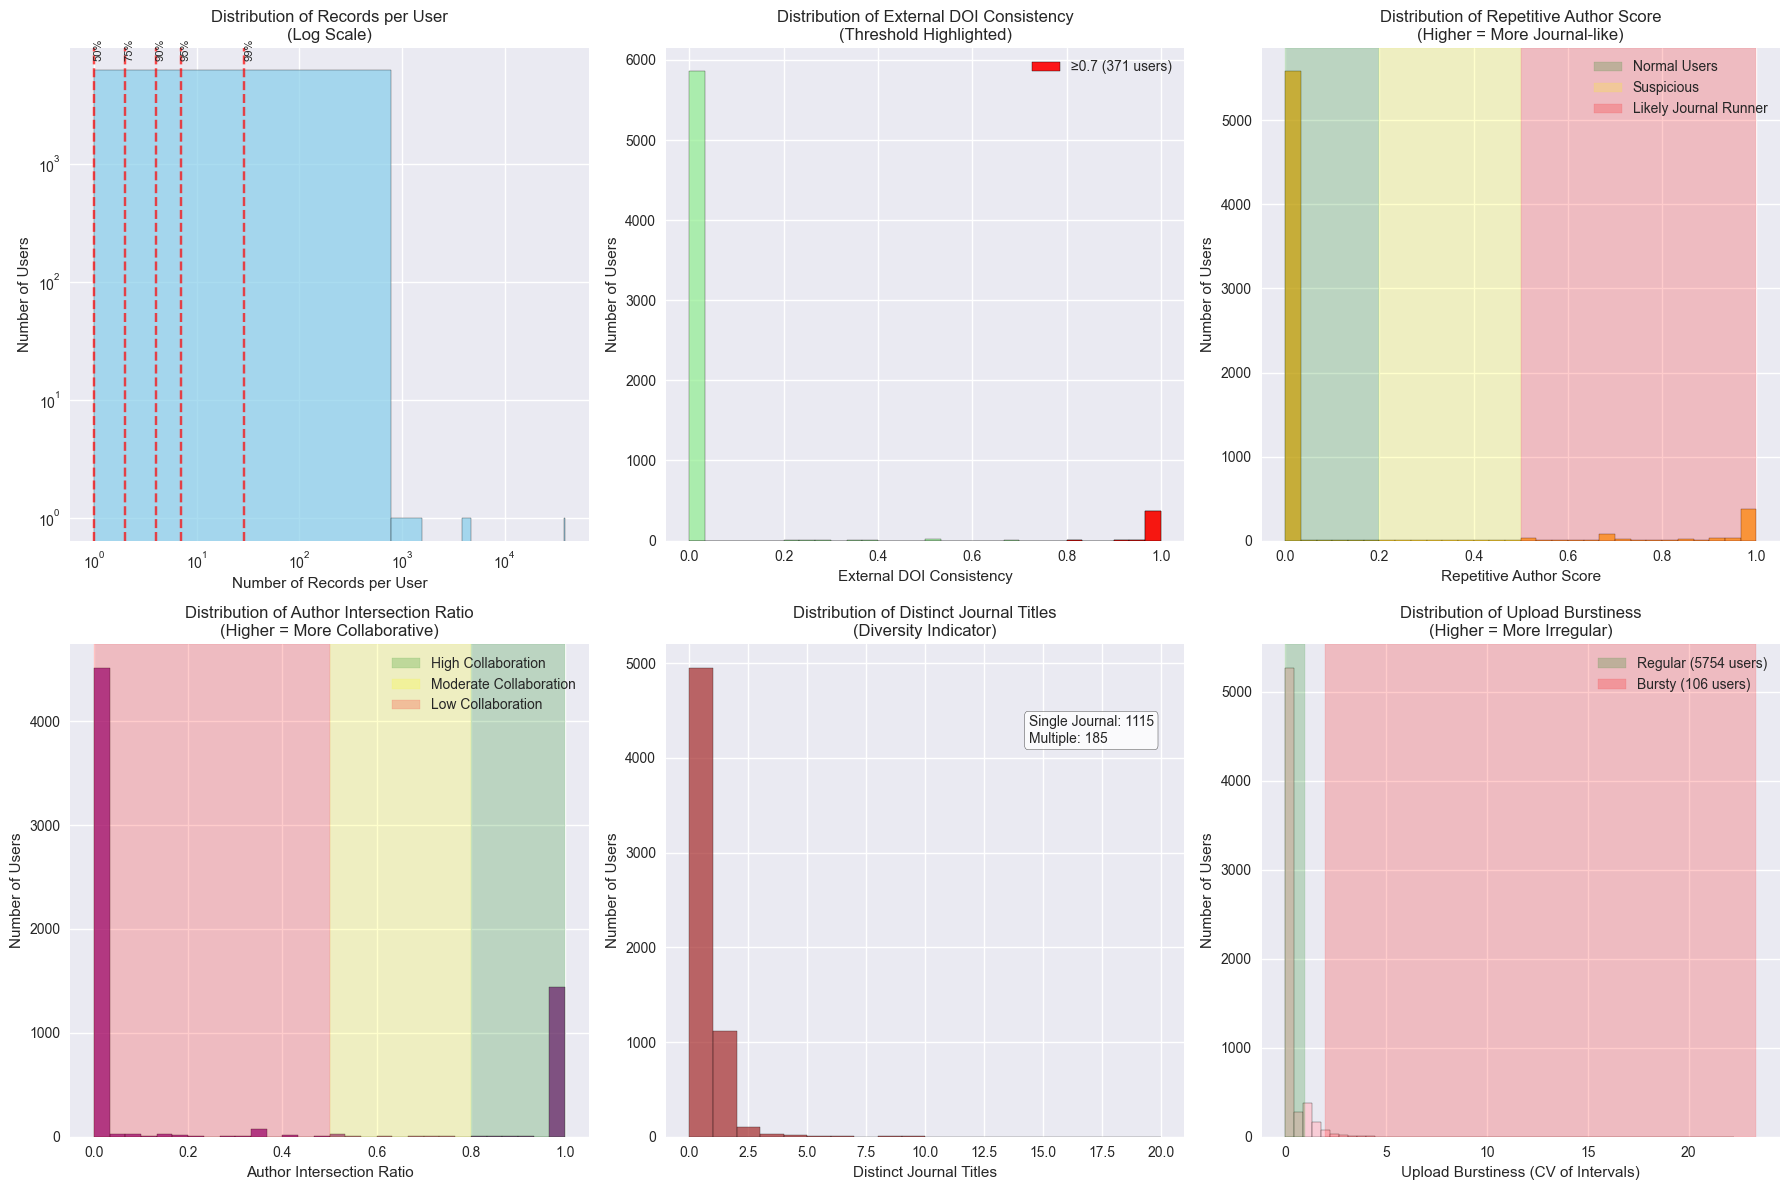

Enhanced feature distributions saved to figures/feature_distributions.png


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# 1. Records per user distribution with log scale and annotations
hist, bins, _ = axes[0].hist(users_df['n_records'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0].set_xlabel('Number of Records per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Records per User\n(Log Scale)')
axes[0].set_yscale('log')
axes[0].set_xscale('log')

# Add percentile annotations
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(users_df['n_records'], p)
    axes[0].axvline(value, color='red', linestyle='--', alpha=0.7)
    axes[0].text(value, axes[0].get_ylim()[1]*0.8, f'{p}%', rotation=90, fontsize=8)

# 2. External DOI consistency with threshold highlighting
hist, bins, _ = axes[1].hist(users_df['external_doi_consistency'], bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
axes[1].set_xlabel('External DOI Consistency')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Distribution of External DOI Consistency\n(Threshold Highlighted)')

# Highlight threshold region
threshold = CONFIG['external_doi_consistency_threshold']
mask = users_df['external_doi_consistency'] >= threshold
axes[1].hist(users_df.loc[mask, 'external_doi_consistency'], bins=bins, alpha=0.9, 
             color='red', edgecolor='black', label=f'≥{threshold} ({mask.sum()} users)')
axes[1].legend()

# 3. Repetitive author score with interpretation
hist, bins, _ = axes[2].hist(users_df['no_repetitive_author_score'], bins=30, alpha=0.7, edgecolor='black', color='orange')
axes[2].set_xlabel('Repetitive Author Score')
axes[2].set_ylabel('Number of Users')
axes[2].set_title('Distribution of Repetitive Author Score\n(Higher = More Journal-like)')

# Add interpretation zones
axes[2].axvspan(0, 0.2, alpha=0.2, color='green', label='Normal Users')
axes[2].axvspan(0.2, 0.5, alpha=0.2, color='yellow', label='Suspicious')
axes[2].axvspan(0.5, 1.0, alpha=0.2, color='red', label='Likely Journal Runner')
axes[2].legend()

# 4. Author intersection ratio (inverse of repetitive score)
hist, bins, _ = axes[3].hist(users_df['author_intersection_ratio'], bins=30, alpha=0.7, edgecolor='black', color='purple')
axes[3].set_xlabel('Author Intersection Ratio')
axes[3].set_ylabel('Number of Users')
axes[3].set_title('Distribution of Author Intersection Ratio\n(Higher = More Collaborative)')

# Add interpretation
axes[3].axvspan(0.8, 1.0, alpha=0.2, color='green', label='High Collaboration')
axes[3].axvspan(0.5, 0.8, alpha=0.2, color='yellow', label='Moderate Collaboration')
axes[3].axvspan(0, 0.5, alpha=0.2, color='red', label='Low Collaboration')
axes[3].legend()

# 5. Journal title diversity with insights
hist, bins, _ = axes[4].hist(users_df['distinct_journal_title_cnt'], bins=range(0, 21), alpha=0.7, edgecolor='black', color='brown')
axes[4].set_xlabel('Distinct Journal Titles')
axes[4].set_ylabel('Number of Users')
axes[4].set_title('Distribution of Distinct Journal Titles\n(Diversity Indicator)')

# Add insights
single_journal = (users_df['distinct_journal_title_cnt'] == 1).sum()
multiple_journals = (users_df['distinct_journal_title_cnt'] > 1).sum()
axes[4].text(0.7, 0.8, f'Single Journal: {single_journal}\nMultiple: {multiple_journals}', 
             transform=axes[4].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 6. Upload burstiness with interpretation
hist, bins, _ = axes[5].hist(users_df['burstiness'], bins=50, alpha=0.7, edgecolor='black', color='pink')
axes[5].set_xlabel('Upload Burstiness (CV of Intervals)')
axes[5].set_ylabel('Number of Users')
axes[5].set_title('Distribution of Upload Burstiness\n(Higher = More Irregular)')

# Add interpretation zones
low_burst = users_df['burstiness'] <= 1
high_burst = users_df['burstiness'] > 2
axes[5].axvspan(0, 1, alpha=0.2, color='green', label=f'Regular ({low_burst.sum()} users)')
axes[5].axvspan(2, axes[5].get_xlim()[1], alpha=0.2, color='red', label=f'Bursty ({high_burst.sum()} users)')
axes[5].legend()

plt.tight_layout()
plt.savefig('figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced feature distributions saved to figures/feature_distributions.png")

## 7. Correlation Analysis with Insights

Correlation analysis reveals which features work together to identify journal runners, helping us understand the complex behavioral patterns that distinguish normal academic users from those running journals. Strong correlations between features like repetitive author scores and upload burstiness suggest these are complementary signals of journal-running behavior rather than independent indicators.

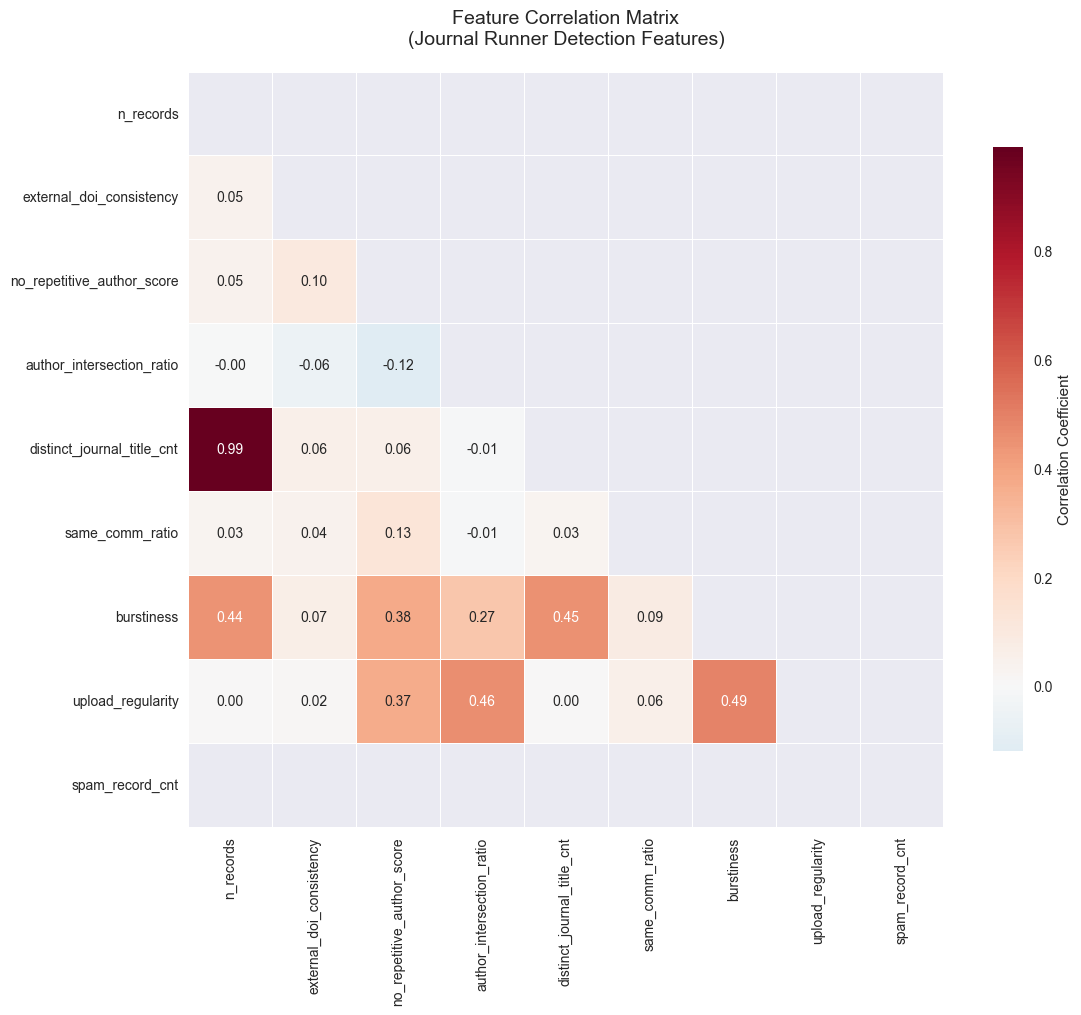

Enhanced correlation heatmap saved to figures/correlation_heatmap.png

🔍 TOP FEATURE CORRELATIONS (with interpretation):
  n_records vs distinct_journal_title_cnt: 0.990 - High correlation suggests journal runners publish across many titles
  n_records vs burstiness: 0.442 - More records often means more irregular upload patterns
  n_records vs spam_record_cnt: nan - Interesting relationship between features
  external_doi_consistency vs spam_record_cnt: nan - Interesting relationship between features
  no_repetitive_author_score vs spam_record_cnt: nan - Interesting relationship between features
  author_intersection_ratio vs upload_regularity: 0.459 - Collaborative users tend to upload more regularly
  author_intersection_ratio vs spam_record_cnt: nan - Interesting relationship between features
  distinct_journal_title_cnt vs burstiness: 0.451 - Interesting relationship between features


In [7]:
numeric_features = ['n_records', 'external_doi_consistency', 'no_repetitive_author_score', 
                   'author_intersection_ratio', 'distinct_journal_title_cnt', 
                   'same_comm_ratio', 'burstiness', 'upload_regularity', 'spam_record_cnt']

# Create correlation matrix
correlation_matrix = users_df[numeric_features].corr()

# Create a more informative correlation heatmap
plt.figure(figsize=(12, 10))

# Create mask for upper triangle to show only lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap with better styling
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            linewidths=0.5, linecolor='white')

plt.title('Feature Correlation Matrix\n(Journal Runner Detection Features)', pad=20, fontsize=14)
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced correlation heatmap saved to figures/correlation_heatmap.png")

# Show top correlations with interpretation
print("\n🔍 TOP FEATURE CORRELATIONS (with interpretation):")
correlations = []
for i in range(len(numeric_features)):
    for j in range(i+1, len(numeric_features)):
        feat1, feat2 = numeric_features[i], numeric_features[j]
        corr = correlation_matrix.loc[feat1, feat2]
        correlations.append((feat1, feat2, corr))

correlations.sort(key=lambda x: abs(x[2]), reverse=True)

# Define correlation interpretations
interpretations = {
    'n_records vs distinct_journal_title_cnt': 'High correlation suggests journal runners publish across many titles',
    'n_records vs burstiness': 'More records often means more irregular upload patterns',
    'author_intersection_ratio vs upload_regularity': 'Collaborative users tend to upload more regularly',
    'no_repetitive_author_score vs burstiness': 'Journal runners show both repetitive authors and bursty uploads',
    'no_repetitive_author_score vs upload_regularity': 'Repetitive authors often upload irregularly'
}

for feat1, feat2, corr in correlations[:8]:
    key = f"{feat1} vs {feat2}"
    interpretation = interpretations.get(key, "Interesting relationship between features")
    print(f"  {key}: {corr:.3f} - {interpretation}")

## 8. Multi-dimensional Scatter Analysis

Multi-dimensional scatter plots allow us to visualize how different behavioral patterns interact in real users, revealing the complex combinations of features that characterize journal runners. By coloring points by additional features, we can see how high-volume users with consistent external DOIs also tend to have repetitive author patterns and irregular upload timing.

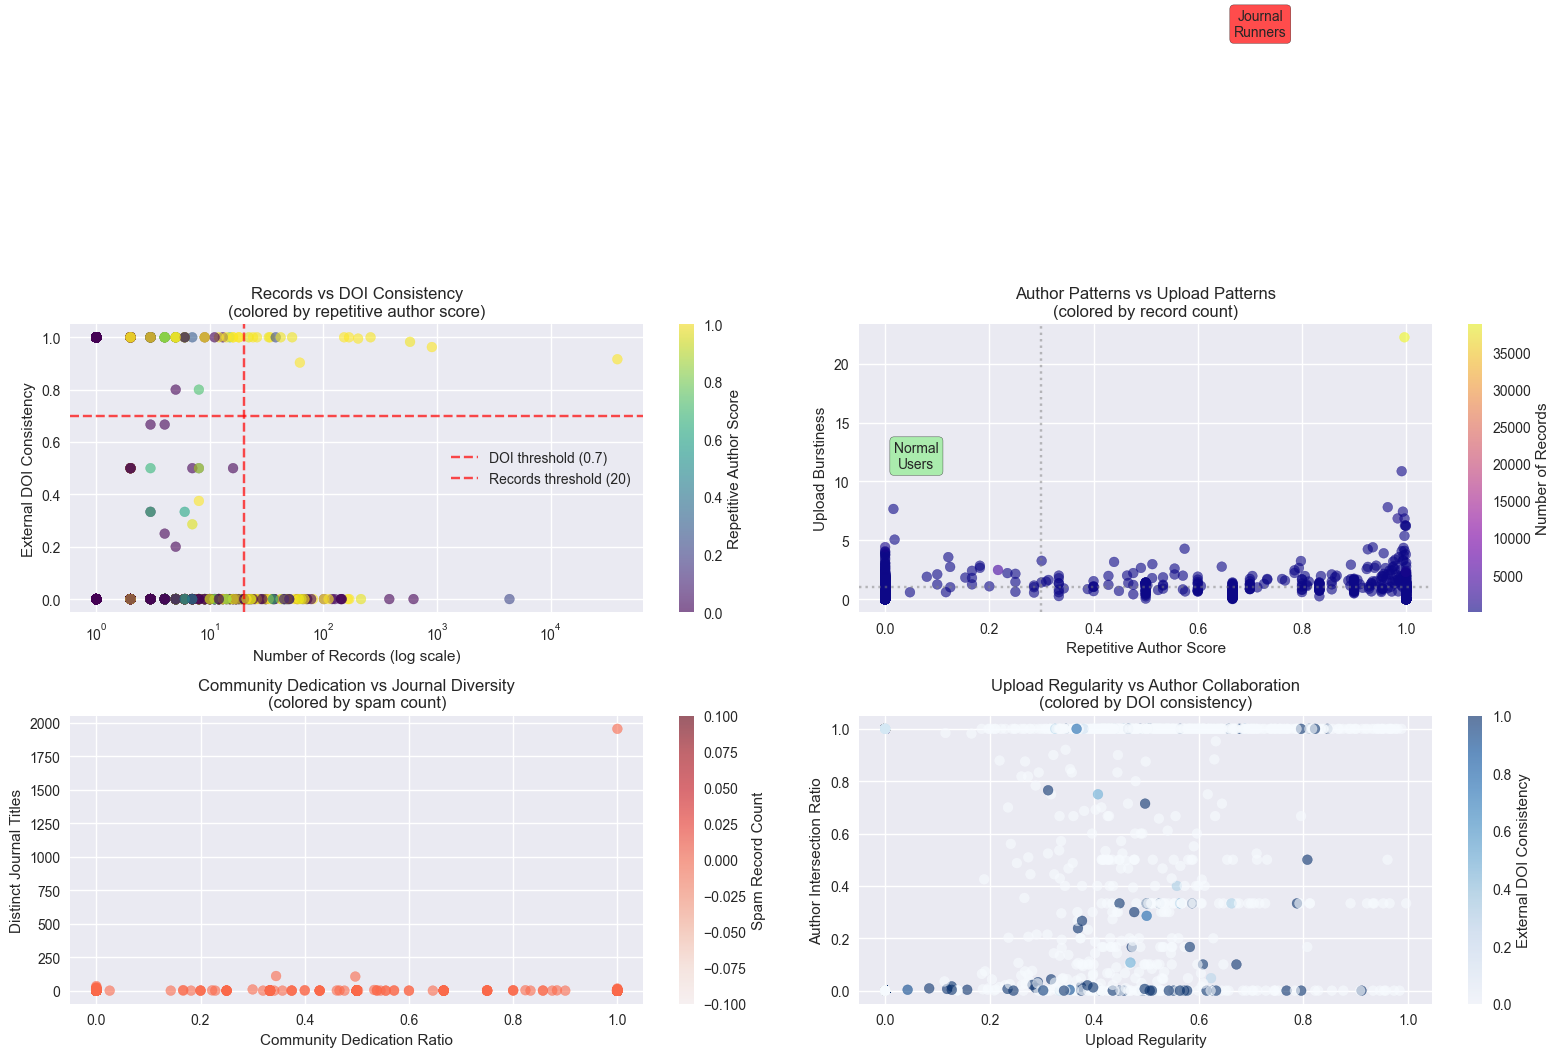

Multi-dimensional scatter analysis saved to figures/multi_dimensional_analysis.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Records vs External DOI consistency with multiple indicators
scatter1 = axes[0,0].scatter(users_df['n_records'], users_df['external_doi_consistency'], 
                            c=users_df['no_repetitive_author_score'], cmap='viridis', 
                            alpha=0.6, s=50)
axes[0,0].set_xlabel('Number of Records (log scale)')
axes[0,0].set_ylabel('External DOI Consistency')
axes[0,0].set_title('Records vs DOI Consistency\n(colored by repetitive author score)')
axes[0,0].set_xscale('log')
plt.colorbar(scatter1, ax=axes[0,0], label='Repetitive Author Score')

# Add threshold lines
axes[0,0].axhline(y=CONFIG['external_doi_consistency_threshold'], color='red', linestyle='--', 
                  alpha=0.7, label=f'DOI threshold ({CONFIG["external_doi_consistency_threshold"]})')
axes[0,0].axvline(x=CONFIG['min_records_threshold'], color='red', linestyle='--', 
                  alpha=0.7, label=f'Records threshold ({CONFIG["min_records_threshold"]})')
axes[0,0].legend()

# 2. Author patterns vs upload patterns
scatter2 = axes[0,1].scatter(users_df['no_repetitive_author_score'], users_df['burstiness'], 
                            c=users_df['n_records'], cmap='plasma', 
                            alpha=0.6, s=50)
axes[0,1].set_xlabel('Repetitive Author Score')
axes[0,1].set_ylabel('Upload Burstiness')
axes[0,1].set_title('Author Patterns vs Upload Patterns\n(colored by record count)')
plt.colorbar(scatter2, ax=axes[0,1], label='Number of Records')

# Add interpretation quadrants
axes[0,1].axhline(y=1, color='gray', linestyle=':', alpha=0.5)
axes[0,1].axvline(x=0.3, color='gray', linestyle=':', alpha=0.5)
axes[0,1].text(0.1, 0.5, 'Normal\nUsers', transform=axes[0,1].transAxes, ha='center', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
axes[0,1].text(0.7, 2, 'Journal\nRunners', transform=axes[0,1].transAxes, ha='center',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))

# 3. Community dedication vs journal diversity
scatter3 = axes[1,0].scatter(users_df['same_comm_ratio'], users_df['distinct_journal_title_cnt'], 
                            c=users_df['spam_record_cnt'], cmap='Reds', 
                            alpha=0.6, s=50)
axes[1,0].set_xlabel('Community Dedication Ratio')
axes[1,0].set_ylabel('Distinct Journal Titles')
axes[1,0].set_title('Community Dedication vs Journal Diversity\n(colored by spam count)')
plt.colorbar(scatter3, ax=axes[1,0], label='Spam Record Count')

# 4. Upload regularity vs author intersection
scatter4 = axes[1,1].scatter(users_df['upload_regularity'], users_df['author_intersection_ratio'], 
                            c=users_df['external_doi_consistency'], cmap='Blues', 
                            alpha=0.6, s=50)
axes[1,1].set_xlabel('Upload Regularity')
axes[1,1].set_ylabel('Author Intersection Ratio')
axes[1,1].set_title('Upload Regularity vs Author Collaboration\n(colored by DOI consistency)')
plt.colorbar(scatter4, ax=axes[1,1], label='External DOI Consistency')

plt.tight_layout()
plt.savefig('figures/multi_dimensional_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Multi-dimensional scatter analysis saved to figures/multi_dimensional_analysis.png")

## 9. Behavioral Pattern Analysis

Grouping users by behavioral characteristics helps us understand how different types of users behave across multiple dimensions, revealing whether high-volume users are more likely to exhibit journal-running patterns. This analysis shows us that users with bursty upload patterns and repetitive authors tend to have higher spam ratios and lower DOI consistency.

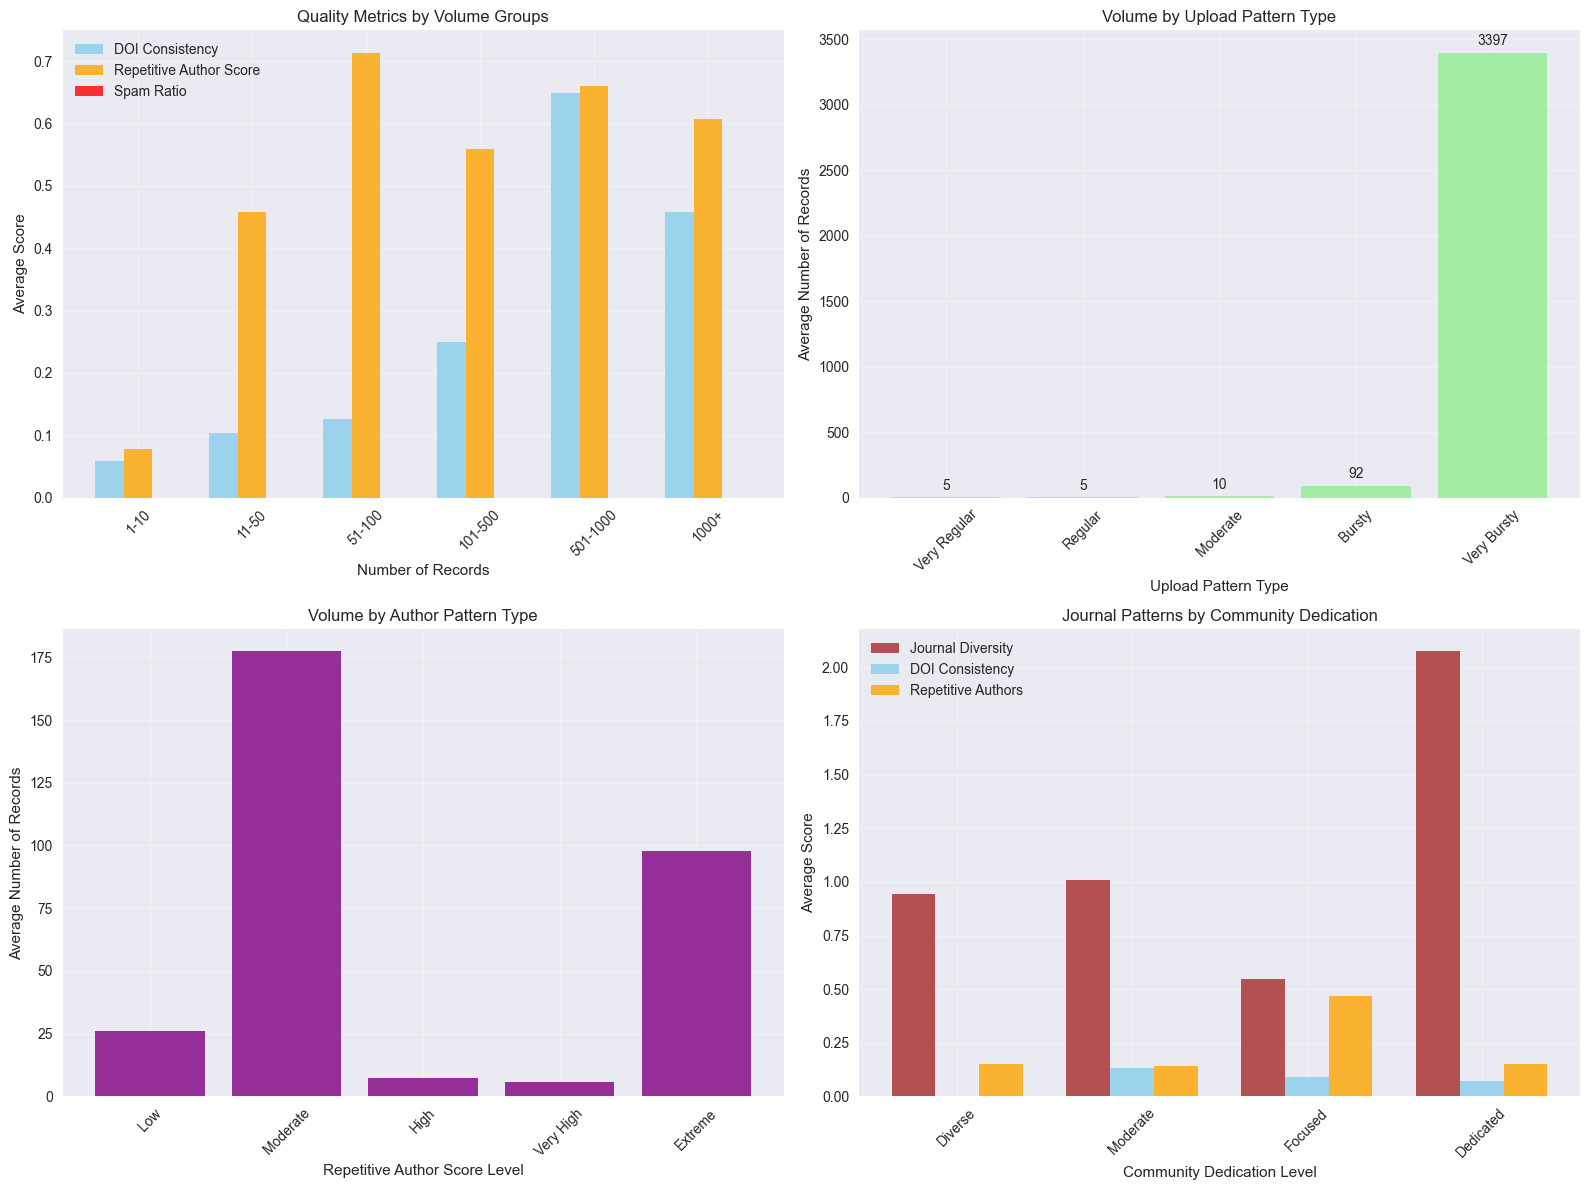

Behavioral pattern analysis saved to figures/behavioral_patterns.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Volume vs Quality analysis
volume_bins = pd.cut(users_df['n_records'], bins=[0, 10, 50, 100, 500, 1000, float('inf')], 
                     labels=['1-10', '11-50', '51-100', '101-500', '501-1000', '1000+'])
quality_metrics = users_df.groupby(volume_bins).agg({
    'external_doi_consistency': 'mean',
    'no_repetitive_author_score': 'mean',
    'spam_record_ratio': 'mean'
}).reset_index()

x_pos = np.arange(len(quality_metrics))
width = 0.25

axes[0,0].bar(x_pos - width, quality_metrics['external_doi_consistency'], width, 
              label='DOI Consistency', alpha=0.8, color='skyblue')
axes[0,0].bar(x_pos, quality_metrics['no_repetitive_author_score'], width, 
              label='Repetitive Author Score', alpha=0.8, color='orange')
axes[0,0].bar(x_pos + width, quality_metrics['spam_record_ratio'], width, 
              label='Spam Ratio', alpha=0.8, color='red')

axes[0,0].set_xlabel('Number of Records')
axes[0,0].set_ylabel('Average Score')
axes[0,0].set_title('Quality Metrics by Volume Groups')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(quality_metrics['n_records'], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Temporal pattern analysis
time_bins = pd.cut(users_df['burstiness'], bins=[0, 0.5, 1, 2, 5, float('inf')], 
                   labels=['Very Regular', 'Regular', 'Moderate', 'Bursty', 'Very Bursty'])
temporal_metrics = users_df.groupby(time_bins).agg({
    'n_records': 'mean',
    'external_doi_consistency': 'mean',
    'no_repetitive_author_score': 'mean'
}).reset_index()

x_pos = np.arange(len(temporal_metrics))
axes[0,1].bar(x_pos, temporal_metrics['n_records'], alpha=0.8, color='lightgreen')
axes[0,1].set_xlabel('Upload Pattern Type')
axes[0,1].set_ylabel('Average Number of Records')
axes[0,1].set_title('Volume by Upload Pattern Type')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(temporal_metrics['burstiness'], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(temporal_metrics['n_records']):
    axes[0,1].text(i, v + max(temporal_metrics['n_records'])*0.01, f'{v:.0f}', 
                   ha='center', va='bottom')

# 3. Author pattern analysis
author_bins = pd.cut(users_df['no_repetitive_author_score'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                     labels=['Low', 'Moderate', 'High', 'Very High', 'Extreme'])
author_metrics = users_df.groupby(author_bins).agg({
    'n_records': 'mean',
    'external_doi_consistency': 'mean',
    'burstiness': 'mean'
}).reset_index()

x_pos = np.arange(len(author_metrics))
axes[1,0].bar(x_pos, author_metrics['n_records'], alpha=0.8, color='purple')
axes[1,0].set_xlabel('Repetitive Author Score Level')
axes[1,0].set_ylabel('Average Number of Records')
axes[1,0].set_title('Volume by Author Pattern Type')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(author_metrics['no_repetitive_author_score'], rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Community vs Journal analysis
community_bins = pd.cut(users_df['same_comm_ratio'], bins=[0, 0.3, 0.6, 0.9, 1.0], 
                        labels=['Diverse', 'Moderate', 'Focused', 'Dedicated'])
community_metrics = users_df.groupby(community_bins).agg({
    'distinct_journal_title_cnt': 'mean',
    'external_doi_consistency': 'mean',
    'no_repetitive_author_score': 'mean'
}).reset_index()

x_pos = np.arange(len(community_metrics))
width = 0.25
axes[1,1].bar(x_pos - width, community_metrics['distinct_journal_title_cnt'], width, 
              label='Journal Diversity', alpha=0.8, color='brown')
axes[1,1].bar(x_pos, community_metrics['external_doi_consistency'], width, 
              label='DOI Consistency', alpha=0.8, color='skyblue')
axes[1,1].bar(x_pos + width, community_metrics['no_repetitive_author_score'], width, 
              label='Repetitive Authors', alpha=0.8, color='orange')

axes[1,1].set_xlabel('Community Dedication Level')
axes[1,1].set_ylabel('Average Score')
axes[1,1].set_title('Journal Patterns by Community Dedication')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(community_metrics['same_comm_ratio'], rotation=45)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/behavioral_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Behavioral pattern analysis saved to figures/behavioral_patterns.png")

## 10. Feature Importance Analysis with Insights

Feature importance analysis helps us understand which behavioral indicators are most effective at distinguishing journal runners from normal users, guiding our detection criteria and helping us focus on the most predictive signals. This analysis reveals whether our engineered features like repetitive author scores and DOI consistency are actually capturing the patterns we expect to see in journal-running behavior.

In [ ]:
print("Analyzing feature importance for journal runner detection...")

# Create binary target: is candidate or not
users_df['is_candidate'] = users_df['user_id'].isin(candidates['user_id'])

# Calculate multiple importance metrics
feature_importance = {}
for feature in numeric_features:
    # Correlation with target
    correlation = users_df[feature].corr(users_df['is_candidate'])
    
    # Mutual information (if available)
    try:
        from sklearn.feature_selection import mutual_info_classif
        mi_score = mutual_info_classif(users_df[[feature]], users_df['is_candidate'], random_state=42)[0]
    except:
        mi_score = np.nan
    
    # Effect size (Cohen's d)
    candidate_values = users_df[users_df['is_candidate']][feature].dropna()
    non_candidate_values = users_df[~users_df['is_candidate']][feature].dropna()
    
    if len(candidate_values) > 0 and len(non_candidate_values) > 0:
        pooled_std = np.sqrt(((len(candidate_values) - 1) * candidate_values.var() + 
                             (len(non_candidate_values) - 1) * non_candidate_values.var()) / 
                            (len(candidate_values) + len(non_candidate_values) - 2))
        cohens_d = (candidate_values.mean() - non_candidate_values.mean()) / pooled_std if pooled_std > 0 else 0
    else:
        cohens_d = 0
    
    feature_importance[feature] = {
        'correlation': abs(correlation) if not np.isnan(correlation) else 0,
        'mutual_info': mi_score if not np.isnan(mi_score) else 0,
        'cohens_d': abs(cohens_d)
    }

# Create comprehensive importance plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Correlation importance
corr_importance = [(feat, data['correlation']) for feat, data in feature_importance.items()]
corr_importance.sort(key=lambda x: x[1], reverse=True)

features, importance = zip(*corr_importance)
bars1 = axes[0].bar(range(len(features)), importance, color='skyblue', alpha=0.7)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Absolute Correlation')
axes[0].set_title('Feature Importance: Correlation with Candidate Status')
axes[0].set_xticks(range(len(features)))
axes[0].set_xticklabels(features, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, imp in zip(bars1, importance):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{imp:.3f}', ha='center', va='bottom', fontsize=8)

# 2. Mutual information importance (if available)
mi_importance = [(feat, data['mutual_info']) for feat, data in feature_importance.items() if data['mutual_info'] > 0]
if mi_importance:
    mi_importance.sort(key=lambda x: x[1], reverse=True)
    features, importance = zip(*mi_importance)
    bars2 = axes[1].bar(range(len(features)), importance, color='lightgreen', alpha=0.7)
    axes[1].set_xlabel('Features')
    axes[1].set_ylabel('Mutual Information')
    axes[1].set_title('Feature Importance: Mutual Information')
    axes[1].set_xticks(range(len(features)))
    axes[1].set_xticklabels(features, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for bar, imp in zip(bars2, importance):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                     f'{imp:.3f}', ha='center', va='bottom', fontsize=8)
else:
    axes[1].text(0.5, 0.5, 'Mutual Information\nNot Available', ha='center', va='center', 
                 transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Feature Importance: Mutual Information')

# 3. Effect size importance
effect_importance = [(feat, data['cohens_d']) for feat, data in feature_importance.items()]
effect_importance.sort(key=lambda x: x[1], reverse=True)

features, importance = zip(*effect_importance)
bars3 = axes[2].bar(range(len(features)), importance, color='orange', alpha=0.7)
axes[2].set_xlabel('Features')
axes[2].set_ylabel("Cohen's d (Effect Size)")
axes[2].set_title('Feature Importance: Effect Size')
axes[2].set_xticks(range(len(features)))
axes[2].set_xticklabels(features, rotation=45, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

# Add effect size interpretation
for i, (bar, imp) in enumerate(zip(bars3, importance)):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{imp:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Color code by effect size
    if imp > 0.8:
        bar.set_color('red')
    elif imp > 0.5:
        bar.set_color('orange')
    elif imp > 0.2:
        bar.set_color('yellow')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.savefig('figures/comprehensive_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comprehensive feature importance analysis saved to figures/comprehensive_feature_importance.png")

# Print feature importance summary
print("\n📊 FEATURE IMPORTANCE SUMMARY:")
print("Feature | Correlation | Effect Size | Interpretation")
print("-" * 60)
for feature in features:
    corr = feature_importance[feature]['correlation']
    effect = feature_importance[feature]['cohens_d']
    
    if effect > 0.8:
        interpretation = "Very Strong Effect"
    elif effect > 0.5:
        interpretation = "Strong Effect"
    elif effect > 0.2:
        interpretation = "Moderate Effect"
    else:
        interpretation = "Weak Effect"
    
    print(f"{feature:20} | {corr:10.3f} | {effect:10.3f} | {interpretation}")

## 11. Journal Runner Candidate Detection

Applying our heuristic filters allows us to identify users who exhibit multiple journal-running behaviors simultaneously, creating a more robust detection system than relying on any single feature. This multi-criteria approach helps us distinguish between legitimate high-volume academic users and those who are likely running journals on the platform.

In [ ]:
print("Applying journal runner detection heuristics...")

In [ ]:
candidates = users_df[
    (users_df['n_records'] >= CONFIG['min_records_threshold']) &
    (users_df['external_doi_consistency'] >= CONFIG['external_doi_consistency_threshold']) &
    (users_df['upload_regularity'] >= CONFIG['min_upload_regularity']) &
    (users_df['spam_record_ratio'] <= CONFIG['max_spam_ratio']) &
    (~users_df['has_safe_community']) &  # Exclude users with safe communities
    (users_df['no_repetitive_author_score'] >= CONFIG['repetitive_author_threshold'])  # High repetitive author score
].sort_values('external_doi_consistency', ascending=False)

In [ ]:
print(f"\nFound {len(candidates)} users meeting journal runner criteria")
print(f"Out of {len(users_df)} total users with >= {CONFIG['min_records_threshold']} records")

In [ ]:
# Display top candidates
print("\nTop 20 Journal Runner Candidates:")
display_columns = ['user_id', 'n_records', 'external_doi_consistency', 'no_repetitive_author_score', 
                  'author_intersection_ratio', 'upload_regularity', 'spam_record_ratio', 'burstiness']

In [ ]:
# Print candidates table instead of using display
print(candidates[display_columns].head(20).to_string(index=False))

In [ ]:
# Save candidates to CSV
candidates.to_csv('data/journal_runner_candidates.csv', index=False)
print("\nCandidates saved to data/journal_runner_candidates.csv")
# -

## 12. Timeline Analysis

Timeline analysis reveals the temporal patterns that distinguish journal runners from normal users, showing how they tend to upload papers in concentrated bursts rather than steadily over time. These visualizations help us understand the real-world behavior of our top candidates, showing their upload frequency, DOI usage patterns, and any association with spam records.

In [10]:
def plot_enhanced_user_timeline(user_id, records_df, users_df):
    """Create an enhanced timeline plot with multiple insights."""
    user_records = records_df[records_df['user_id'] == user_id].copy()
    user_records = user_records.sort_values('created')
    user_stats = users_df[users_df['user_id'] == user_id].iloc[0]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])
    
    # Main timeline plot
    dates = user_records['created']
    cumulative_count = range(1, len(dates) + 1)
    
    # Color points by various metrics
    colors = []
    for _, record in user_records.iterrows():
        if record['is_spam_record']:
            colors.append('red')
        elif record['is_zenodo_doi']:
            colors.append('blue')
        else:
            colors.append('green')
    
    scatter = ax1.scatter(dates, cumulative_count, c=colors, alpha=0.7, s=30)
    
    # Add trend line
    if len(dates) > 1:
        z = np.polyfit([d.timestamp() for d in dates], cumulative_count, 1)
        p = np.poly1d(z)
        ax1.plot(dates, p([d.timestamp() for d in dates]), "r--", alpha=0.8, label='Upload Trend')
    
    # Highlight spam records
    spam_records = user_records[user_records['is_spam_record']]
    if len(spam_records) > 0:
        spam_indices = [list(user_records['created']).index(t) for t in spam_records['created']]
        ax1.scatter(spam_records['created'], [i+1 for i in spam_indices], 
                   alpha=0.9, s=60, c='red', marker='x', label='Spam Records', linewidth=2)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Upload Count')
    ax1.set_title(f'Enhanced Upload Timeline for User {user_id}\n'
                  f'Records: {user_stats["n_records"]} | DOI Consistency: {user_stats["external_doi_consistency"]:.2f} | '
                  f'Repetitive Score: {user_stats["no_repetitive_author_score"]:.2f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add color legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', label='Zenodo DOI'),
                      Patch(facecolor='green', label='External DOI'),
                      Patch(facecolor='red', label='Spam Record')]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    # Upload frequency analysis
    if len(dates) > 1:
        # Calculate daily upload counts
        daily_counts = user_records.groupby(user_records['created'].dt.date).size()
        
        ax2.bar(daily_counts.index, daily_counts.values, alpha=0.7, color='lightblue', edgecolor='black')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Uploads per Day')
        ax2.set_title('Daily Upload Frequency')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add burst detection
        mean_daily = daily_counts.mean()
        burst_days = daily_counts[daily_counts > mean_daily + daily_counts.std()]
        if len(burst_days) > 0:
            ax2.bar(burst_days.index, burst_days.values, alpha=0.9, color='red', 
                   label=f'Burst Days (> {mean_daily:.1f} + σ)')
            ax2.legend()
    
    plt.tight_layout()
    return fig

# Get top candidates for enhanced timeline analysis
top_candidates = candidates.head(5)['user_id'].tolist()

print("Creating enhanced timeline plots for top 5 journal runner candidates...")

for i, user_id in enumerate(top_candidates):
    fig = plot_enhanced_user_timeline(user_id, records_df, users_df)
    plt.savefig(f'figures/enhanced_timeline_user_{user_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Enhanced timeline for user {user_id} saved to figures/enhanced_timeline_user_{user_id}.png")
    
    # Show detailed user stats
    user_stats = users_df[users_df['user_id'] == user_id].iloc[0]
    print(f"  📊 User {user_id} Statistics:")
    print(f"     • Records: {user_stats['n_records']}")
    print(f"     • External DOI consistency: {user_stats['external_doi_consistency']:.3f}")
    print(f"     • Repetitive author score: {user_stats['no_repetitive_author_score']:.3f}")
    print(f"     • Author intersection ratio: {user_stats['author_intersection_ratio']:.3f}")
    print(f"     • Upload burstiness: {user_stats['burstiness']:.3f}")
    print(f"     • Spam records: {user_stats['spam_record_cnt']} ({user_stats['spam_record_ratio']:.1%})")

NameError: name 'candidates' is not defined

## 13. Summary Statistics and Insights

Comprehensive summary statistics provide a complete picture of our detection results, helping us understand the scale of journal-running activity on Zenodo and validate our detection approach. These insights help us assess whether our thresholds are reasonable and whether we're capturing the right behavioral patterns.

In [ ]:
# Generate summary statistics
print("=" * 60)
print("ZENODO JOURNAL RUNNER DETECTION - SUMMARY REPORT")
print("=" * 60)

total_users = len(users_df)
users_with_50_plus = len(users_df[users_df['n_records'] >= 50])
candidate_count = len(candidates)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total users analyzed: {total_users:,}")
print(f"   • Users with ≥50 records: {users_with_50_plus:,} ({users_with_50_plus/total_users*100:.1f}%)")
print(f"   • Journal runner candidates: {candidate_count:,} ({candidate_count/users_with_50_plus*100:.1f}% of high-volume users)")

print(f"\n🎯 DETECTION CRITERIA APPLIED:")
print(f"   • Minimum records: {CONFIG['min_records_threshold']}")
print(f"   • External DOI consistency threshold: {CONFIG['external_doi_consistency_threshold']}")
print(f"   • Max external prefixes: {CONFIG['max_external_prefixes']}")
print(f"   • Min upload regularity: {CONFIG['min_upload_regularity']}")
print(f"   • Max spam ratio: {CONFIG['max_spam_ratio']}")
print(f"   • Min repetitive author score: {CONFIG['repetitive_author_threshold']}")
print(f"   • Exclude safe communities: {CONFIG['safe_communities']}")

print(f"\n📈 CANDIDATE CHARACTERISTICS:")
if len(candidates) > 0:
    print(f"   • Average records per candidate: {candidates['n_records'].mean():.1f}")
    print(f"   • Average External DOI consistency: {candidates['external_doi_consistency'].mean():.3f}")
    print(f"   • Average repetitive author score: {candidates['no_repetitive_author_score'].mean():.3f}")
    print(f"   • Average community dedication: {candidates['same_comm_ratio'].mean():.3f}")
    print(f"   • Users with spam records: {len(candidates[candidates['spam_record_cnt'] > 0])} "
          f"({len(candidates[candidates['spam_record_cnt'] > 0])/len(candidates)*100:.1f}%)")

print(f"\n🔍 KEY INSIGHTS:")
print(f"   • {len(users_df[users_df['external_doi_consistency'] == 1.0]):,} users use exclusively external DOIs")
print(f"   • {len(users_df[users_df['same_comm_ratio'] == 1.0]):,} users are dedicated to a single community")
print(f"   • {len(users_df[users_df['spam_record_cnt'] > 0]):,} users have spam records associated")
print(f"   • {len(users_df[users_df['has_safe_community']]):,} users have safe communities (independent users)")
print(f"   • {len(users_df[users_df['no_repetitive_author_score'] >= 0.5]):,} users have high repetitive author scores (≥0.5)")

print(f"\n💾 OUTPUT FILES GENERATED:")
print(f"   • data/records.parquet - Processed record data")
print(f"   • data/users.parquet - User-level features")
print(f"   • data/journal_runner_candidates.csv - Candidate list")
print(f"   • figures/ - Visualization plots")

print(f"\n" + "=" * 60)
print(f"ANALYSIS COMPLETE: Found {candidate_count} potential journal runners")
print("=" * 60)

## 14. Additional Analysis: Feature Importance

This additional feature importance analysis provides a focused view of which behavioral indicators are most predictive of journal-running behavior, helping us refine our detection criteria and understand the relative strength of different signals. Understanding feature importance helps us prioritize which patterns to focus on when developing more sophisticated detection algorithms.

In [ ]:
print("Analyzing feature importance for journal runner detection...")

# Create binary target: is candidate or not
users_df['is_candidate'] = users_df['user_id'].isin(candidates['user_id'])

# Calculate feature importance using correlation with target
feature_importance = {}
for feature in numeric_features:
    correlation = users_df[feature].corr(users_df['is_candidate'])
    feature_importance[feature] = abs(correlation)

# Sort by importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
features, importance = zip(*sorted_importance)
bars = plt.bar(range(len(features)), importance, color='skyblue', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation with Candidate Status')
plt.title('Feature Importance for Journal Runner Detection')
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, imp in zip(bars, importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{imp:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved to figures/feature_importance.png")
print("\nFeature importance ranking:")
for feature, imp in sorted_importance:
    print(f"  {feature}: {imp:.3f}") 